In [2]:
from fastkaggle import *
from fastai.vision.all import *

comp = 'paddy-disease-classification'
path = setup_comp(comp, install='fastai "timm>=0.6.2.dev0"')
path.ls()

/opt/conda/lib/python3.8/site-packages/apex/pyprof/__init__.py:5: FutureWarning: pyprof will be removed by the end of June, 2022
  warnings.warn("pyprof will be removed by the end of June, 2022", FutureWarning)


(#4) [Path('paddy-disease-classification/sample_submission.csv'),Path('paddy-disease-classification/test_images'),Path('paddy-disease-classification/train.csv'),Path('paddy-disease-classification/train_images')]

In [3]:
train_path = path/"train_images"
files = get_image_files(train_path)

(480, 640)


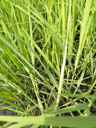

In [4]:
img = PILImage.create(files[0])
print(img.size)
img.to_thumb(128)

In [5]:
# def f(o): return PILImage.create(o)
# sizes = parallel(f, files, n_workers=8)
# pd.Series(sizes).value_counts()

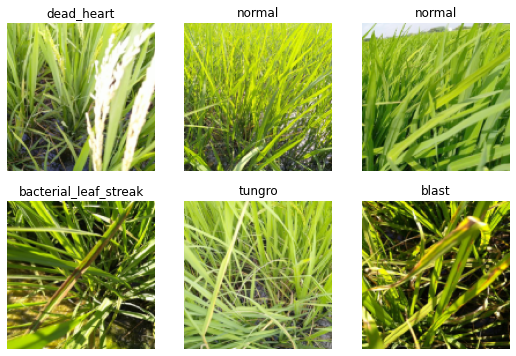

In [6]:
dls = ImageDataLoaders.from_folder(train_path, valid_pct=0.2,
                                  item_tfms=Resize(480, method="squish"),
                                  batch_tfms=aug_transforms(size=128, min_scale=0.75))
dls.show_batch(max_n=6)

In [7]:
learn = vision_learner(dls, 'resnet26d', metrics=error_rate, path='.').to_fp16()

/opt/conda/lib/python3.8/site-packages/torch/nn/modules/module.py:1402: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


SuggestedLRs(valley=0.0008317637839354575, slide=0.0063095735386013985)

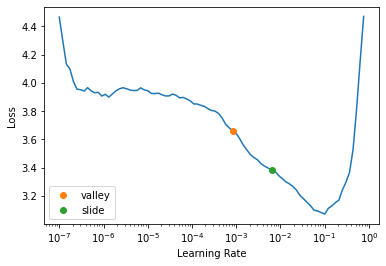

In [8]:
learn.lr_find(suggest_funcs=(valley, slide))

In [9]:
learn.fine_tune(8, 0.01)

In [10]:
learn.export('models/model.pkl')

In [11]:
ss = pd.read_csv(path/'sample_submission.csv')
ss

image_id  label
0     200001.jpg    NaN
1     200002.jpg    NaN
2     200003.jpg    NaN
3     200004.jpg    NaN
4     200005.jpg    NaN
...          ...    ...
3464  203465.jpg    NaN
3465  203466.jpg    NaN
3466  203467.jpg    NaN
3467  203468.jpg    NaN
3468  203469.jpg    NaN

[3469 rows x 2 columns]

In [12]:
test_files = get_image_files(path/'test_images').sorted()
test_dl = dls.test_dl(test_files)

In [13]:
probs, _, idxs = learn.get_preds(dl=test_dl, with_decoded=True)
idxs

tensor([7, 8, 3,  ..., 8, 1, 5])

In [14]:
dls.vocab

['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']

In [15]:
mapping = dict(enumerate(dls.vocab))
results = pd.Series(idxs.numpy(), name="idxs").map(mapping)
results

0                       hispa
1                      normal
2                       blast
3                       blast
4                       blast
                ...          
3464               dead_heart
3465                    hispa
3466                   normal
3467    bacterial_leaf_streak
3468               dead_heart
Name: idxs, Length: 3469, dtype: object

In [16]:
ss['label'] = results

In [17]:
ss.to_csv('subm.csv', index=False)
!head subm.csv

image_id,label
200001.jpg,hispa
200002.jpg,normal
200003.jpg,blast
200004.jpg,blast
200005.jpg,blast
200006.jpg,tungro
200007.jpg,dead_heart
200008.jpg,brown_spot
200009.jpg,hispa
